In [32]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking',
'home': '/home/vvalenzuela/MOAD/analysis-vicente/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/animations'}

In [4]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [5]:
#Definitions
start = datetime(2023, 1, 1) #Start date
length = 30 # Set Time length [days] 

In [6]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(start,path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [7]:
fname_bio = []
fname_sal =[]
for i in range(0,length+1):
    fname_bio.append(make_prefix(start+timedelta(i),path['NEMO'])+'_biol_T.nc')
    fname_sal.append(make_prefix(start+timedelta(i),path['NEMO'])+'_grid_T.nc')    

From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$

Where:

- $[PBDE]_p$ represents the PBDEs concentration retained on the filter.

- $[PBDE]_{d,c}$ is the PBDEs concentrations pasing through the filter.

- $[POC]$ is the Particulate Organic Carbon.

We can use this parameter in Ocean Parcels for changing states between colloids and particuated PBDEs coming out of the pipe.


Option 1: Use the discharge data for PBDEs and use it with the POC data for a modified version of the equation above.

In [8]:
PBDE_data = pd.read_excel('/ocean/vvalenzuela/MOAD/analysis-vicente/PBDEs_DATA/predicted_discharges.xlsx')
time = PBDE_data['Unnamed: 0'].values
PBDE_data = PBDE_data.drop('Unnamed: 0', axis=1)
PBDE_data = PBDE_data.set_index(time)

In [9]:
hourly_discharge = pd.DataFrame(columns=['PBDE 28', 'PBDE 99', 'PBDE 209'])
for pbde in ['PBDE 28', 'PBDE 99', 'PBDE 209']:
    hourly_discharge[pbde] = pd.to_numeric(PBDE_data[pbde], errors='coerce').resample("1h").interpolate("linear")

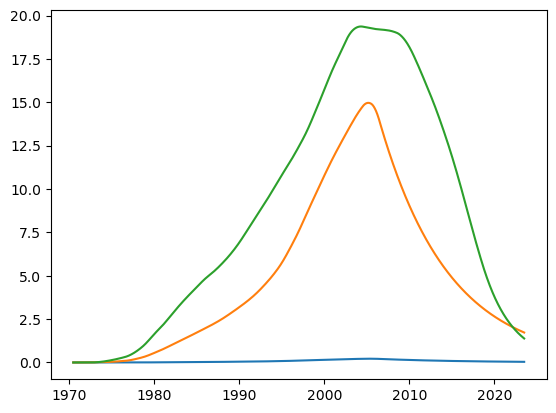

In [10]:
plt.plot(hourly_discharge)

In [11]:
bio = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01aug22/SalishSea_1h_20220801_20220801_biol_T.nc')
var = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01aug22/SalishSea_1h_20220801_20220801_grid_T.nc')

In [12]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [13]:
clat = [49.2]
clon = [-123.4]
#
a, b = finder(clat[0], clon[0])

In [12]:
depth = bio.deptht.values

In [13]:
dd = 0
dd1 = 9 
dd2 = 26
poc = []
doc = []
sal = []
poc1 = []
doc1 = []
sal1 = []
poc2 = []
doc2 = []
sal2 = []
for i in range(length+1):
    bio_data = xr.open_dataset(fname_bio[i])
    sal_data = xr.open_dataset(fname_sal[i])
    #
    poc_data = ((bio_data['particulate_organic_nitrogen'][:,dd,a,b]*(16/106)).values)
    doc_data = ((bio_data['dissolved_organic_nitrogen'][:,dd,a,b]*(16/106)).values)
    sali_data = ((sal_data['vosaline'][:,dd,a,b]).values)
    #
    poc_data1 = ((bio_data['particulate_organic_nitrogen'][:,dd1,a,b]*(16/106)).values)
    doc_data1 = ((bio_data['dissolved_organic_nitrogen'][:,dd1,a,b]*(16/106)).values)
    sali_data1 = ((sal_data['vosaline'][:,dd1,a,b]).values)
    #
    poc_data2 = ((bio_data['particulate_organic_nitrogen'][:,dd2,a,b]*(16/106)).values)
    doc_data2 = ((bio_data['dissolved_organic_nitrogen'][:,dd2,a,b]*(16/106)).values)
    sali_data2 = ((sal_data['vosaline'][:,dd2,a,b]).values)
    #
    poc.append(poc_data)
    doc.append(doc_data)
    sal.append(sali_data)
    #
    poc1.append(poc_data1)
    doc1.append(doc_data1)
    sal1.append(sali_data1)    
    #
    poc2.append(poc_data2)
    doc2.append(doc_data2)
    sal2.append(sali_data2)
#
poc_array = np.concatenate(poc)
doc_array = np.concatenate(doc)
sal_array = np.concatenate(sal)
#
poc_array1 = np.concatenate(poc1)
doc_array1 = np.concatenate(doc1)
sal_array1 = np.concatenate(sal1)
#
poc_array2 = np.concatenate(poc2)
doc_array2 = np.concatenate(doc2)
sal_array2 = np.concatenate(sal2)


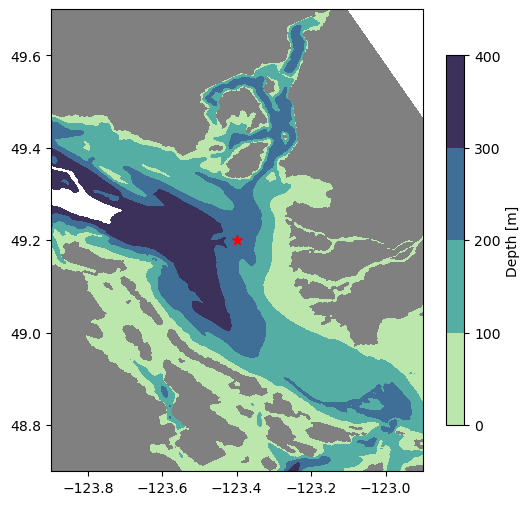

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
#
blevels = list(np.arange(0,500,100))
#
im=ax.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax.scatter(clon[0],clat[0],zorder=3,marker='*',c='r',s=50)
#
ax.set_ylim([clat[0]-.5,clat[0]+.5])
ax.set_xlim([clon[0]-.5,clon[0]+.5])
#
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.8)
cbar.set_label('Depth [m]')

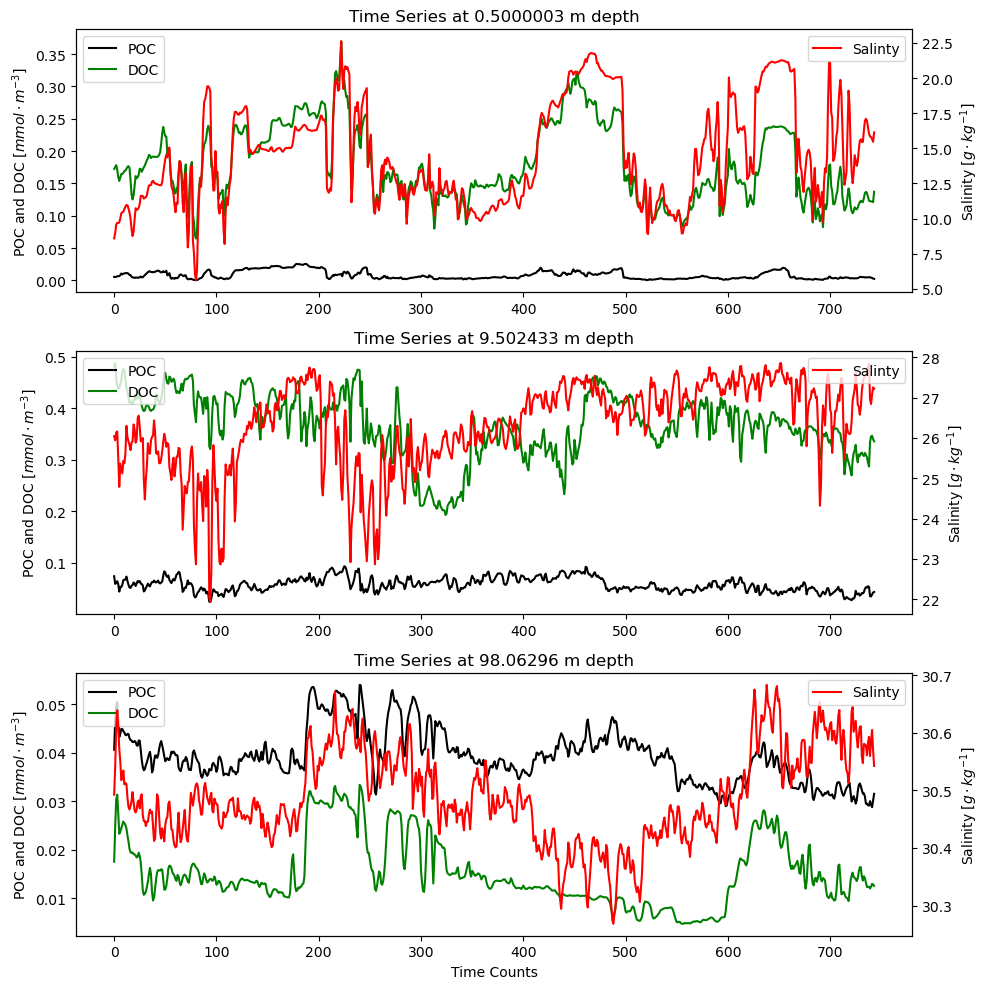

In [15]:
fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(poc_array, 'k', label = 'POC')
ax[0].plot(doc_array, 'g', label = 'DOC')
ax[0].set_ylabel(r'POC and DOC [$mmol \cdot m^{-3}$]')
#
ax1=ax[0].twinx()
#
ax1.plot(sal_array, 'r', label = 'Salinty')
ax1.set_ylabel(r'Salinity [$g \cdot kg^{-1}$]')
#
ax[0].legend(loc = 'upper left')
ax1.legend(loc = 'upper right')
#
ax[0].set_title('Time Series at ' + str(depth[dd]) + ' m depth')
########
ax[1].plot(poc_array1, 'k', label = 'POC')
ax[1].plot(doc_array1, 'g', label = 'DOC')
ax[1].set_ylabel(r'POC and DOC [$mmol \cdot m^{-3}$]')

#
ax2=ax[1].twinx()
#
ax2.plot(sal_array1, 'r', label = 'Salinty')
ax2.set_ylabel(r'Salinity [$g \cdot kg^{-1}$]')
#
ax[1].legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
#
ax[1].set_title('Time Series at ' + str(depth[dd1]) + ' m depth')

##########
ax[2].plot(poc_array2, 'k', label = 'POC')
ax[2].plot(doc_array2, 'g', label = 'DOC')
ax[2].set_ylabel(r'POC and DOC [$mmol \cdot m^{-3}$]')

#
ax3=ax[2].twinx()
#
ax3.plot(sal_array2, 'r', label = 'Salinty')
ax3.set_ylabel(r'Salinity [$g \cdot kg^{-1}$]')
#
ax[2].legend(loc = 'upper left')
ax3.legend(loc = 'upper right')
#
ax[2].set_xlabel('Time Counts')
ax[2].set_title('Time Series at ' + str(depth[dd2]) + ' m depth')
#
plt.tight_layout()


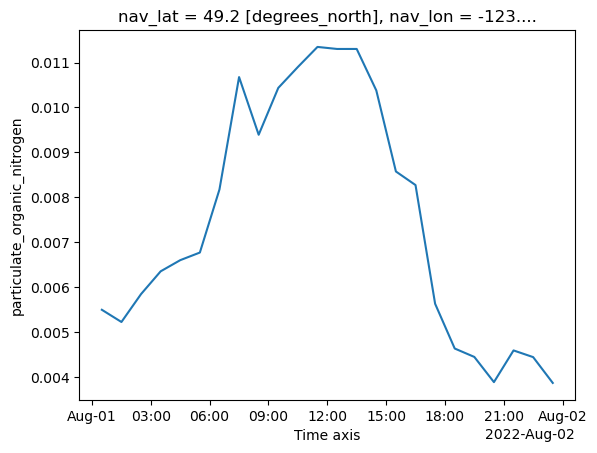

In [16]:
(bio['particulate_organic_nitrogen'][:,0,a,b]*(16/106)).plot()

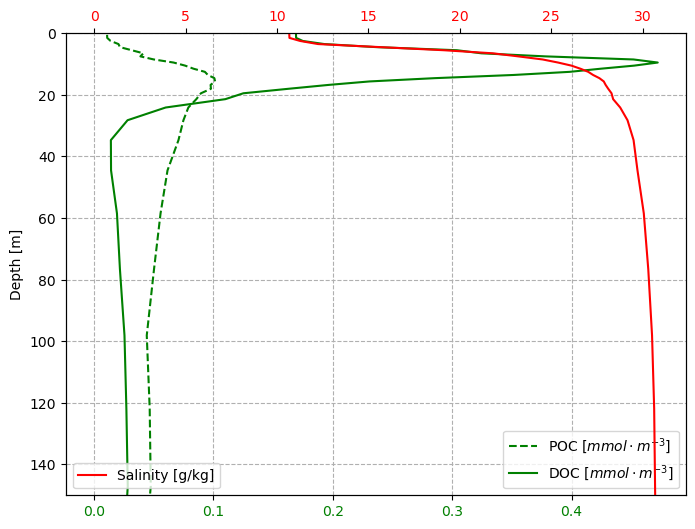

In [17]:
t = 10
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bio['particulate_organic_nitrogen'][t,:,a,b]*(16/106), bio['particulate_organic_nitrogen'].deptht,'--g', label = r'POC $[mmol \cdot m^{-3}]$')
ax.plot(bio['dissolved_organic_nitrogen'][t,:,a,b]*(16/106), bio['particulate_organic_nitrogen'].deptht,'g', label = r'DOC $[mmol \cdot m^{-3}]$')
ax.tick_params(axis="x", labelcolor='g')
ax.legend(loc='lower right')
#
ax1=ax.twiny()
ax1.plot(var['vosaline'][t,:,a,b], var['vosaline'].deptht,'r', label = r'Salinity [g/kg]')
ax1.tick_params(axis="x", labelcolor='r')
ax1.legend(loc='lower left')
#
ax.grid(linestyle = '--')
ax.set_ylim(0,150)
ax.set_ylabel('Depth [m]')


plt.gca().invert_yaxis()


In [18]:
POC = bio['particulate_organic_nitrogen']*(16/106)
DOC = bio['dissolved_organic_nitrogen']*(16/106)
coords = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')

In [19]:
poc_mean = np.mean(bio['particulate_organic_nitrogen'][:,:,:,:]*(16/106), axis=1)
doc_mean = np.mean(bio['dissolved_organic_nitrogen'][:,:,:,:]*(16/106), axis=1)

In [20]:
ParcelsRandom.random()

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2945/parcels_random_04fd0d95-2c2a-4146-b18f-2faf0dbfe473.c


0.47739705443382263

$$\textbf{From here working with monthly data to get POC values}$$

Here the idea is to create a POC parameter from the SalishSeaCast model output. The monthly data is for making it easier to work with. Different regions are going to be extracted for further analysis and final decisions of an "accurate" POC value.


After this analysis, the idea is to use thi value for differenciating the PBDEs phases between Colloidal and Particulate forms.


In [15]:
path_months = '/results2/SalishSea/month-avg.202111/'

In [16]:
def monthly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

In [17]:
monthly_prefix(start, path_months)

['/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_biol_T_20230101_20230131.nc']

In [18]:
fname_bio_monthly = []
fname_sal_monthly =[]
months = 12
for i in range(1,months+1):
    fname_bio_monthly.append(monthly_prefix(start+relativedelta(month=i),path_months, area='biol_T_'))
    fname_sal_monthly.append(monthly_prefix(start+relativedelta(month=i),path_months, area='grid_T_'))

Here I want to extract different regions from the Salish Sea to compare POC values and create the new "changing phase value"

In [105]:
poc = xr.open_dataset(fname_bio_monthly[0][0])['particulate_organic_nitrogen']*(16/106)

In [106]:
bathymetry = xr.open_dataset(path['bat']).Bathymetry
box_gridX = [[110, 250], [150, 350], [280, 370]]
box_gridY = [[560, 730], [400, 560], [310, 400]]
#
#### Take slices of data for the three different regions:
NSoG = poc.isel(gridY=slice(box_gridY[0][0],box_gridY[0][1]), gridX=slice(box_gridX[0][0],box_gridX[0][1]))
CSoG = poc.isel(gridY=slice(box_gridY[1][0],box_gridY[1][1]), gridX=slice(box_gridX[1][0],box_gridX[1][1]))
SSoG = poc.isel(gridY=slice(box_gridY[2][0],box_gridY[2][1]), gridX=slice(box_gridX[2][0],box_gridX[2][1]))

Plotting for looking at how it's changing in depth for one averaged month

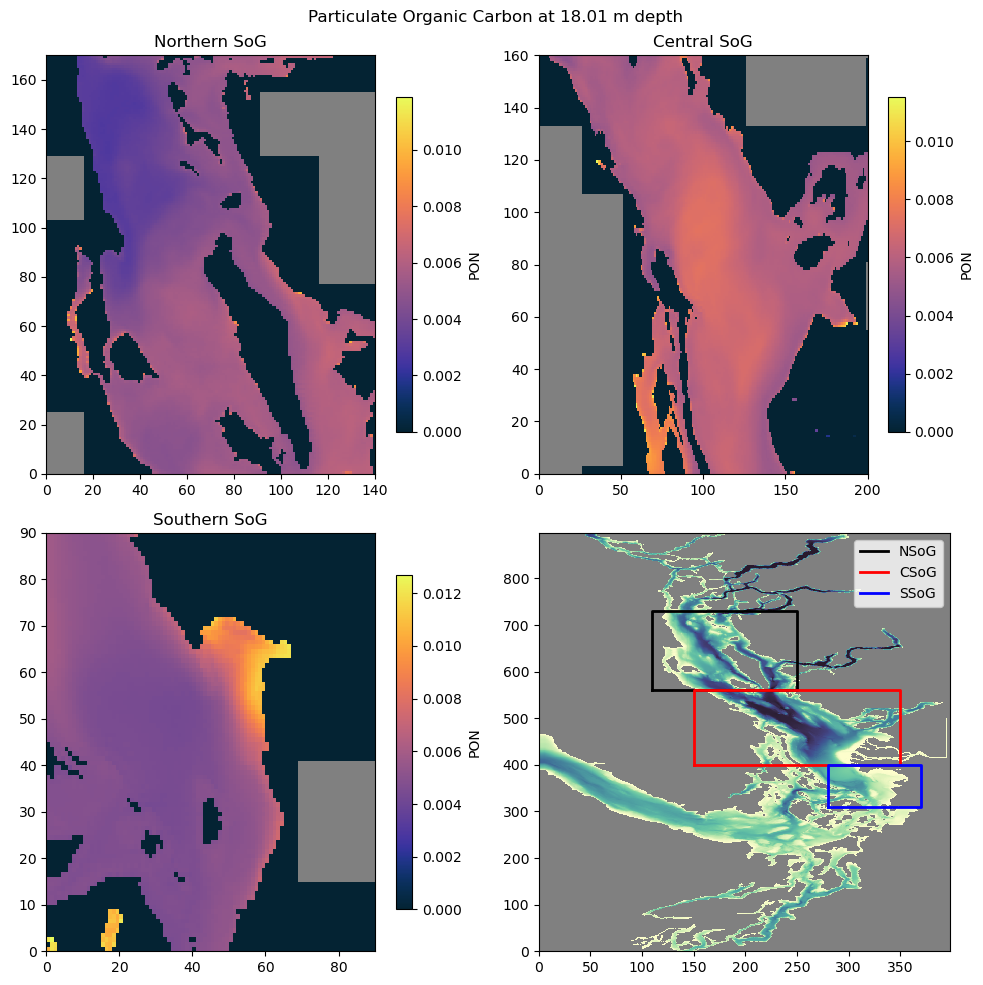

In [125]:
dd = 17
cmap_poc = cmocean.cm.thermal
cmap_poc.set_bad('grey')
#
fig, ax = plt.subplots(2,2,figsize=(10,10))
north = ax[0,0].pcolormesh(NSoG[0,dd,:,:], cmap=cmap_poc)
central = ax[0,1].pcolormesh(CSoG[0,dd,:,:], cmap=cmap_poc)
south = ax[1,0].pcolormesh(SSoG[0,dd,:,:], cmap=cmap_poc)
#
ax[1,1].pcolormesh(bathymetry, cmap=cmap)
ax[1,1].plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
ax[1,1].plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
ax[1,1].plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
ax[1,1].legend()
#
ax[0,0].set_title('Northern SoG')
ax[0,1].set_title('Central SoG')
ax[1,0].set_title('Southern SoG')
#
cbar = fig.colorbar(north, ax=ax[0,0], location='right', shrink=0.8)
cbar.set_label('PON')
#
cbar1 = fig.colorbar(central, ax=ax[0,1], location='right', shrink=0.8)
cbar1.set_label('PON')
#
cbar2 = fig.colorbar(south, ax=ax[1,0], location='right', shrink=0.8)
cbar2.set_label('PON')
#
plt.suptitle('Particulate Organic Carbon at ' + str(np.round(poc.depth.values[dd], 2)) + ' m depth')
#
plt.tight_layout()


Lets calculate the depth mean for each one of these regions:

In [131]:
NSoG_mean = np.mean(NSoG[0,:,:,:], axis=0)
CSoG_mean = np.mean(CSoG[0,:,:,:], axis=0)
SSoG_mean = np.mean(SSoG[0,:,:,:], axis=0)

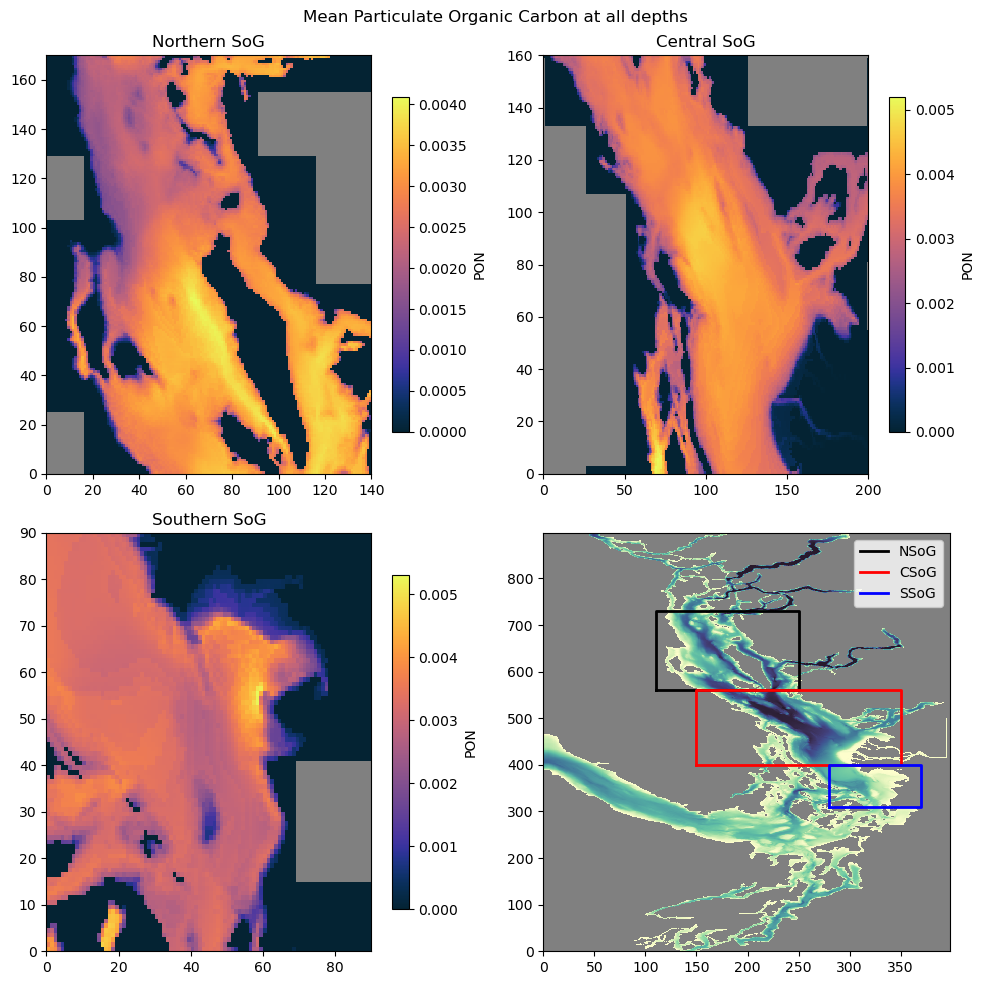

In [132]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
north = ax[0,0].pcolormesh(NSoG_mean, cmap=cmap_poc)
central = ax[0,1].pcolormesh(CSoG_mean, cmap=cmap_poc)
south = ax[1,0].pcolormesh(SSoG_mean, cmap=cmap_poc)
#
ax[1,1].pcolormesh(bathymetry, cmap=cmap)
ax[1,1].plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
ax[1,1].plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
ax[1,1].plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
ax[1,1].legend()
#
ax[0,0].set_title('Northern SoG')
ax[0,1].set_title('Central SoG')
ax[1,0].set_title('Southern SoG')
#
cbar = fig.colorbar(north, ax=ax[0,0], location='right', shrink=0.8)
cbar.set_label('PON')
#
cbar1 = fig.colorbar(central, ax=ax[0,1], location='right', shrink=0.8)
cbar1.set_label('PON')
#
cbar2 = fig.colorbar(south, ax=ax[1,0], location='right', shrink=0.8)
cbar2.set_label('PON')
#
plt.suptitle('Mean Particulate Organic Carbon at all depths')
#
plt.tight_layout()

Now, lets calculate the mean for all the regions, having just a single values for each one of them:

In [139]:
POC_NSoG = np.mean(NSoG_mean).values
POC_CSoG = np.mean(CSoG_mean).values
POC_SSoG = np.mean(SSoG_mean).values

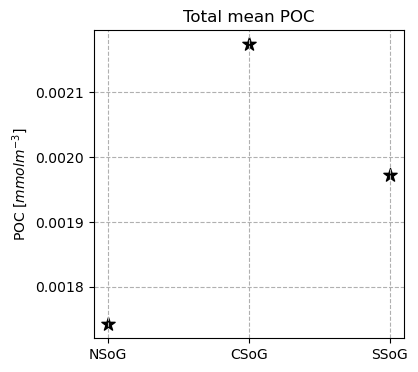

In [152]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(['NSoG','CSoG','SSoG'], [POC_NSoG, POC_CSoG, POC_SSoG], c = 'k', marker = '*', s=100)
ax.set_ylabel(r'POC [$mmol m^{-3}$]')
ax.set_title('Total mean POC')
ax.grid(linestyle = '--')

Now, lets see how this 'total mean POC' changes through the year:

In [160]:
POC_NSoG_year = []
POC_CSoG_year = []
POC_SSoG_year = []
for i in range(0, len(fname_sal_monthly)):
    poc_year = xr.open_dataset(fname_bio_monthly[i][0])['particulate_organic_nitrogen']*(16/106)
    #### Take slices of data for the three different regions:
    NSoG_year = poc_year.isel(gridY=slice(box_gridY[0][0],box_gridY[0][1]), gridX=slice(box_gridX[0][0],box_gridX[0][1]))
    CSoG_year = poc_year.isel(gridY=slice(box_gridY[1][0],box_gridY[1][1]), gridX=slice(box_gridX[1][0],box_gridX[1][1]))
    SSoG_year = poc_year.isel(gridY=slice(box_gridY[2][0],box_gridY[2][1]), gridX=slice(box_gridX[2][0],box_gridX[2][1]))
    #
    POC_NSoG_year.append(np.mean(NSoG_year[0,:,:,:]))
    POC_CSoG_year.append(np.mean(CSoG_year[0,:,:,:]))
    POC_SSoG_year.append(np.mean(SSoG_year[0,:,:,:]))        

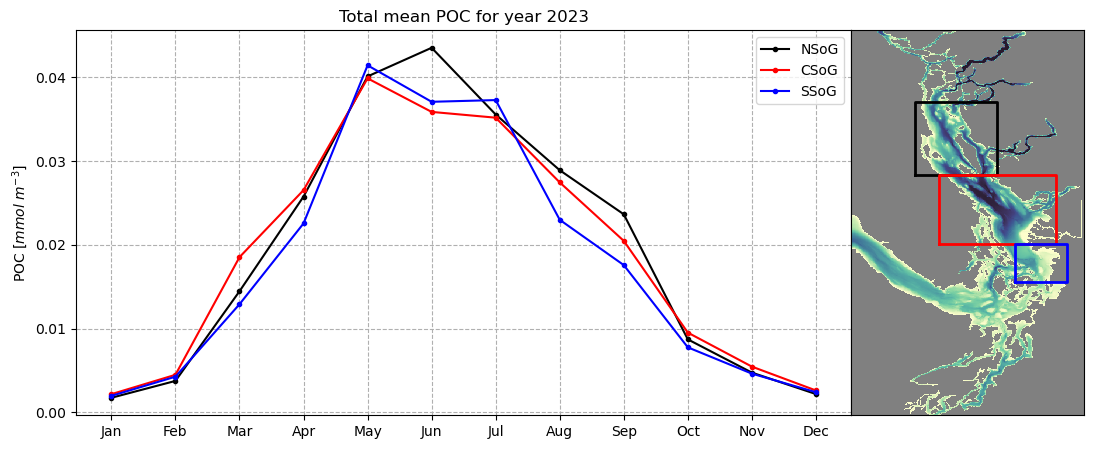

In [189]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(meses, POC_NSoG_year, '.-k', label = 'NSoG')
ax.plot(meses, POC_CSoG_year, '.-r', label = 'CSoG')
ax.plot(meses, POC_SSoG_year, '.-b', label = 'SSoG')
ax.legend(loc = 'upper right')
ax.set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax.set_title('Total mean POC for year 2023')
ax.grid(linestyle = '--')
##### Small map for regions reference
#
axins = ax.inset_axes([1, 0, 0.3, 1])
#
prof = axins.pcolormesh(bathymetry, cmap=cmap)
axins.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
axins.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
axins.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)



In [ ]:
#